## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.utils import get_file, plot_model

In [145]:
sns.set_style("white")
plt.style.use("seaborn-white")

C:\Users\kksoo\AppData\Local\Temp\ipykernel_10368\1588269023.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


### 데이터 로드

In [146]:
path = get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

path

'C:\\Users\\kksoo\\.keras\\datasets\\auto-mpg.data'

In [147]:
col_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

### 데이터 확인

In [148]:
raw_dataset = pd.read_csv(path, names=col_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)

df = raw_dataset.copy()

df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [149]:
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [150]:
df.dropna(inplace=True)

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [151]:
df["Origin"].unique()

array([1, 3, 2], dtype=int64)

In [152]:
origin = df.pop("Origin")

In [153]:
ohe_df = pd.get_dummies(origin, columns=["USA", "Europe", "Japan"], dtype="f")
ohe_df = ohe_df.rename(columns={1: "USA", 2: "Europe", 3: "Japan"})
df = pd.concat([df, ohe_df], axis=1)

df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [154]:
x_train = df.sample(frac=0.8, random_state=42)
x_test = df.drop(x_train.index)

#### 데이터 조사

c:\Users\kksoo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


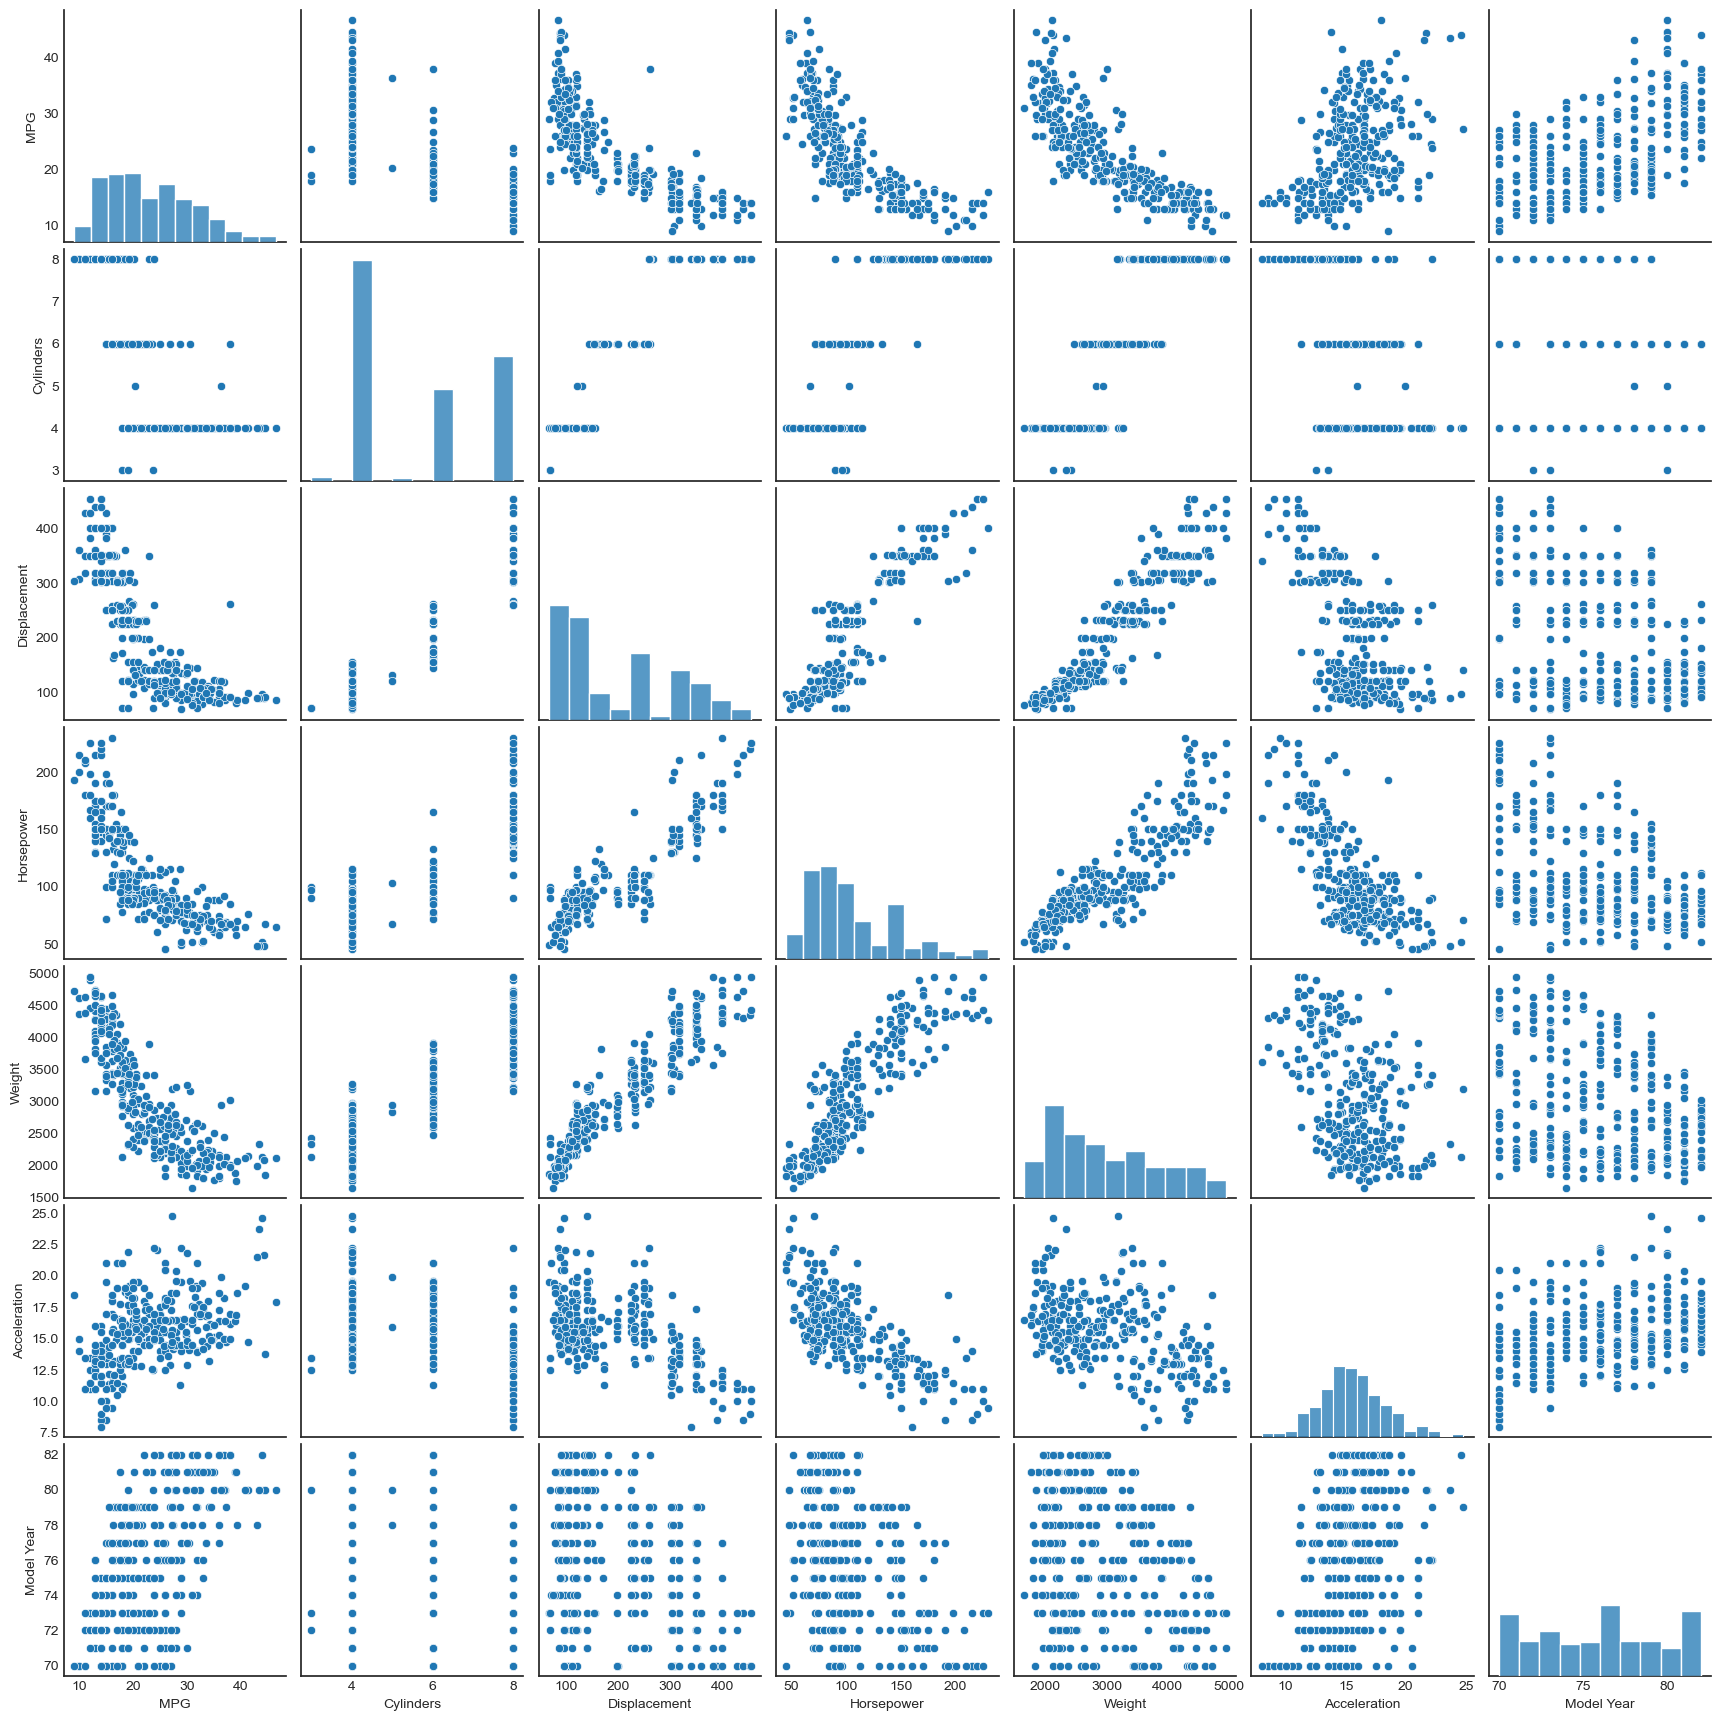

In [155]:
col_names.remove("Origin")
sns.pairplot(x_train[col_names])

In [156]:
target = "MPG"

df.drop(columns=target).describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.625000,0.173469,0.201531
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.484742,0.379136,0.401656
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,1.000000,0.000000,0.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


#### 데이터의 특성과 레이블 분리

In [157]:
y_train = x_train.pop(target)
y_test = x_test.pop(target)

#### 데이터 정규화

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_preprocessed = scaler.fit_transform(x_train)
x_test_preprocessed = scaler.transform(x_test)

### 모델 구성

In [159]:
def build_model():
    inp = Input(shape=(len(x_train.columns), ), name="Input")
    hidden_1 = Dense(64, activation="relu", name="Dense_1")(inp)
    hidden_2 = Dense(32, activation="relu", name="Dense_2")(hidden_1)
    out = Dense(1, activation="relu", name="Output")(hidden_2)

    model = Model(inputs=inp, outputs=out)

    model.compile(
        loss="mse",
        optimizer=RMSprop(),
        metrics=["mae", "mse"]
    )

    return model

In [160]:
model = build_model()

In [161]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 Dense_1 (Dense)             (None, 64)                640       
                                                                 
 Dense_2 (Dense)             (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


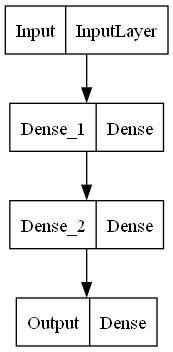

In [162]:
plot_model(model)

### 샘플 데이터 확인

In [166]:
sample_batch = pd.DataFrame(x_train_preprocessed[:10], columns=df.columns.drop(target))
sample_res = model.predict(sample_batch)

sample_batch

1/1 [==============================] - 0s 48ms/step


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,-0.887156,-0.957895,-0.934247,-0.952259,0.889278,-1.061828,-1.288804,2.194269,-0.505964
1,-0.887156,-0.722783,0.228150,-0.245712,0.067583,0.567230,-1.288804,2.194269,-0.505964
2,-0.887156,-1.004918,-1.161673,-1.405802,0.317664,0.567230,-1.288804,-0.455733,1.976424
3,-0.887156,-1.004918,-0.908978,-1.225085,1.782425,-1.333337,0.775913,-0.455733,-0.505964
4,-0.887156,-0.544098,-0.504666,-0.251542,0.031857,1.653269,0.775913,-0.455733,-0.505964
5,-0.887156,-0.948491,-0.782630,-0.991901,0.317664,0.024211,-1.288804,-0.455733,1.976424
6,1.429410,1.901070,1.617973,2.028998,-1.254274,-1.333337,0.775913,-0.455733,-0.505964
7,-0.887156,-0.948491,-0.782630,-0.863650,0.960730,0.295721,-1.288804,-0.455733,1.976424
8,0.271127,0.255284,-0.277240,0.301104,0.174761,-0.247299,0.775913,-0.455733,-0.505964
9,-0.887156,-1.221221,-1.439637,-1.327686,1.425167,-0.790318,-1.288804,2.194269,-0.505964


### 모델 학습

In [167]:
epochs = 1_000
history = model.fit(
    x_train_preprocessed, y_train,
    epochs=epochs,
    validation_split=0.2,
    batch_size=20
)

Epoch 1/1000
13/13 [==============================] - 1s 15ms/step - loss: 552.4608 - mae: 22.1749 - mse: 552.4608 - val_loss: 465.7409 - val_mae: 20.1522 - val_mse: 465.7409
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 485.6306 - mae: 20.6469 - mse: 485.6306 - val_loss: 406.5138 - val_mae: 18.6538 - val_mse: 406.5138
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 416.5424 - mae: 18.9278 - mse: 416.5424 - val_loss: 343.3191 - val_mae: 16.9204 - val_mse: 343.3191
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 339.0534 - mae: 16.8630 - mse: 339.0533 - val_loss: 273.1808 - val_mae: 14.8188 - val_mse: 273.1808
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 258.3923 - mae: 14.4629 - mse: 258.3923 - val_loss: 206.8964 - val_mae: 12.5830 - val_mse: 206.8964
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 183.4366 - mae: 11.9686 - mse: 183.4366 - val_loss: 146

### 모델 학습 시각화

In [168]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [169]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,552.460815,22.174910,552.460815,465.740875,20.152229,465.740875,0
1,485.630554,20.646896,485.630554,406.513763,18.653795,406.513763,1
2,416.542450,18.927786,416.542450,343.319061,16.920351,343.319061,2
3,339.053406,16.863024,339.053345,273.180756,14.818765,273.180756,3
4,258.392303,14.462877,258.392303,206.896408,12.582952,206.896408,4
...,...,...,...,...,...,...,...
995,3.546863,1.254677,3.546863,5.416359,1.837603,5.416359,995
996,3.402516,1.238472,3.402516,5.736624,1.765090,5.736624,996
997,3.728348,1.277168,3.728348,4.850052,1.708308,4.850052,997
998,3.497696,1.218651,3.497696,4.837994,1.682995,4.837994,998


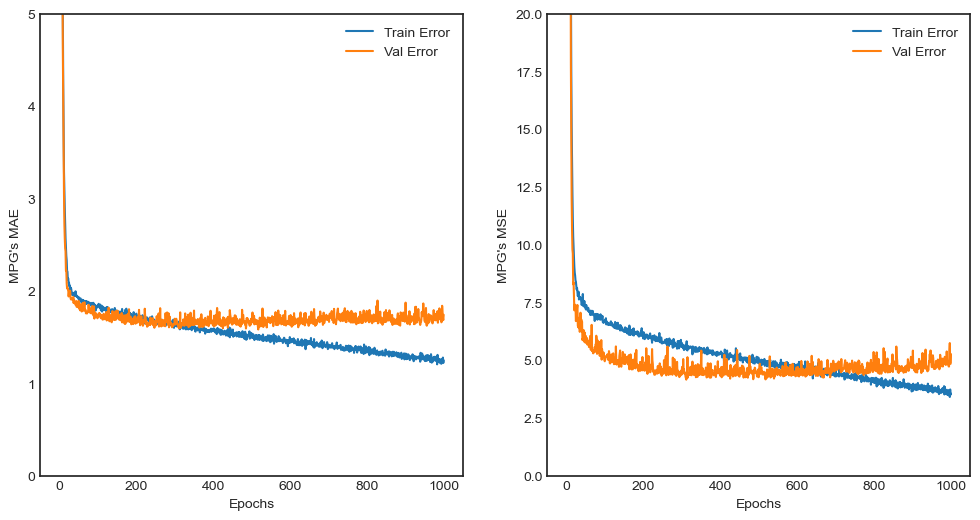

In [171]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.xlabel("Epochs")
    plt.ylabel("MPG's MAE")
    plt.plot(hist["epoch"], hist["mae"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.ylabel("MPG's MSE")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    plt.ylim([0, 20])
    plt.legend()

    plt.show()

plot_history(history)

### EarlyStopping을 이용한 규제화

In [172]:
from keras.callbacks import EarlyStopping

In [173]:
model = build_model()

early_stop = EarlyStopping(patience=10, monitor="val_loss")

history = model.fit(
    x_train_preprocessed, y_train,
    epochs=epochs,
    validation_split=0.2,
    batch_size=20,
    callbacks=[early_stop]
)

Epoch 1/1000
13/13 [==============================] - 1s 13ms/step - loss: 577.6429 - mae: 22.6973 - mse: 577.6429 - val_loss: 492.9756 - val_mae: 20.7987 - val_mse: 492.9756
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 519.5153 - mae: 21.4347 - mse: 519.5153 - val_loss: 440.2671 - val_mae: 19.5381 - val_mse: 440.2671
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 455.3608 - mae: 19.9576 - mse: 455.3608 - val_loss: 381.3444 - val_mae: 18.0471 - val_mse: 381.3444
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 380.9075 - mae: 18.1521 - mse: 380.9075 - val_loss: 312.3549 - val_mae: 16.1511 - val_mse: 312.3549
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 298.9019 - mae: 15.9044 - mse: 298.9019 - val_loss: 242.8422 - val_mae: 14.0111 - val_mse: 242.8422
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 217.8231 - mae: 13.3379 - mse: 217.8231 - val_loss: 175

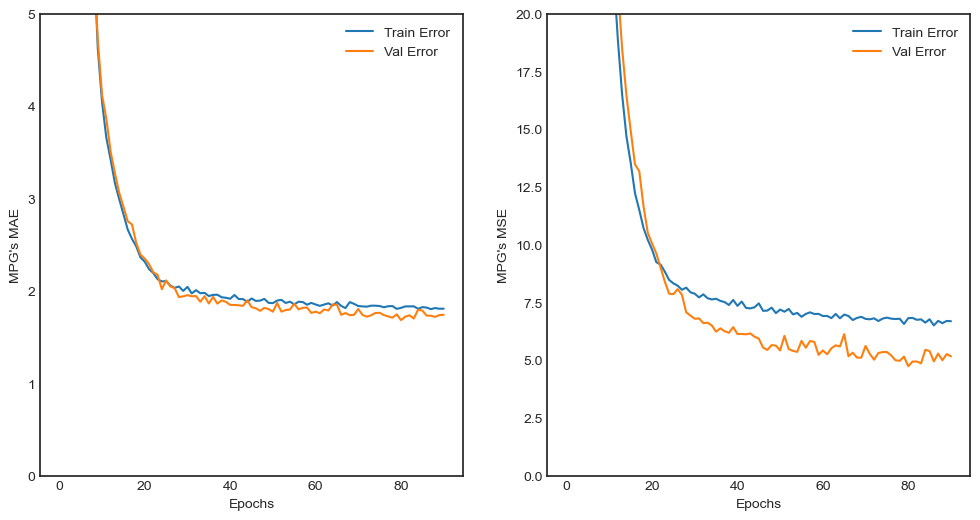

In [174]:
plot_history(history)

### 모델 평가

In [176]:
loss, mae, mse = model.evaluate(x_test_preprocessed, y_test, verbose=2)

3/3 - 0s - loss: 6.3772 - mae: 1.8541 - mse: 6.3772 - 30ms/epoch - 10ms/step


### 학습된 모델을 통한 예측

3/3 [==============================] - 0s 2ms/step


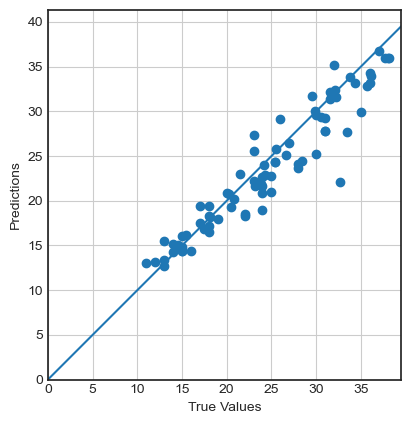

In [180]:
y_pred = model.predict(x_test_preprocessed).flatten()

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.axis("equal")
plt.axis("square")
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

plt.show()

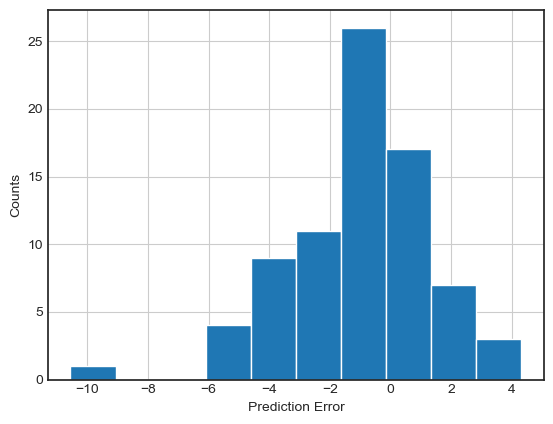

In [181]:
error = y_pred - y_test

plt.hist(error)
plt.xlabel("Prediction Error")
plt.ylabel("Counts")
plt.grid()

plt.show()